In [1]:
%pip install tf_keras_vis tflite-support-nightly

Note: you may need to restart the kernel to use updated packages.


# Create your dataset

1) Choose which classes you would like to add.

2) Create a dataset with your own photos

3) Separate your dataset into train and test subsets.

In [2]:
import os
import pandas as pd
from glob import glob

def create_dataframe_from_directories(path):
    data = []

    for label_dir in os.listdir(path):
        if os.path.isfile(label_dir):
            continue

        label_path_path = os.path.join(path, label_dir)
        for file in os.listdir(label_path_path):
            data.append([os.path.join(label_path_path, file), label_dir])
        
    return pd.DataFrame(data, columns = ["path", "label"])

In [3]:
train_df = create_dataframe_from_directories("dataset_train")
test_df = create_dataframe_from_directories("dataset_test")

In [4]:
LABEL_NAMES = pd.unique(train_df['label'])
LABEL_NAMES

array(['noisette', 'pecan', 'cajoux'], dtype=object)

**TODO**: Display some images of your dataset

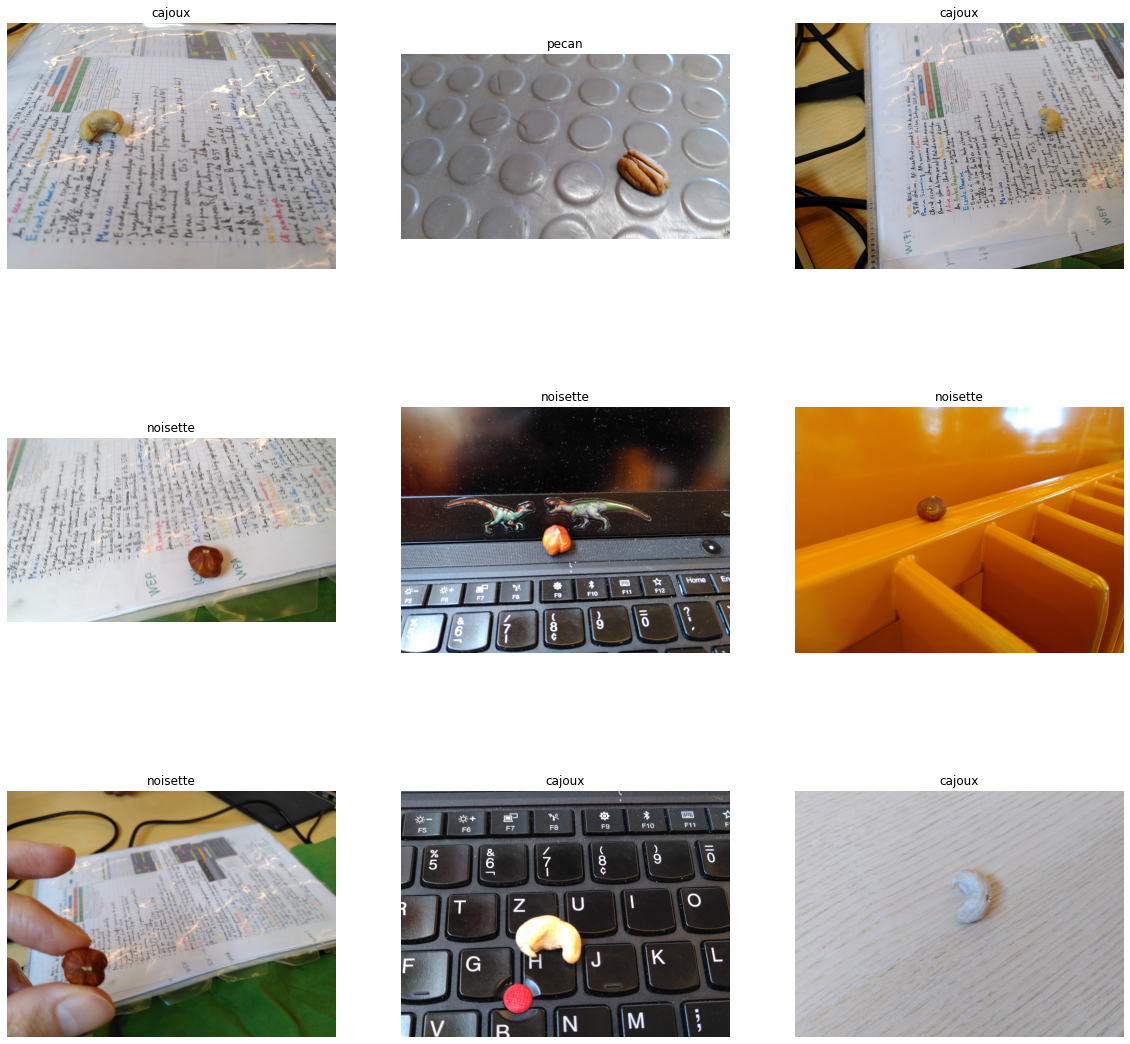

In [5]:
import matplotlib.pyplot as plt
import PIL
import PIL.Image
 
plt.figure(figsize=(20, 20))

i = 0
for _, rowdata in train_df.sample(frac=1).head(9).iterrows():
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(PIL.Image.open(rowdata.path))
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1

# Explore your dataset

**TODO**: count the number of examples per classes and plot an histogram of it

[Text(0, 0, '100.0'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '46.0'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '129.0')]

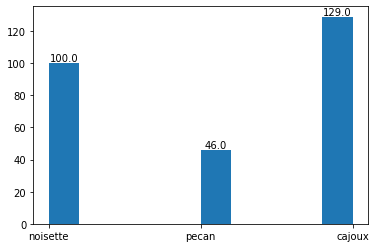

In [6]:
count, edge, bars = plt.hist(train_df['label'])
plt.bar_label(bars, labels=[v if v > 0 else '' for v in bars.datavalues])

# Preprocessing steps

In [7]:
from tensorflow.keras.layers import (
    Resizing, Rescaling,
)
import tensorflow as tf
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras import layers

IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

image_augmentations = Sequential([
    # TODO: choose some image augmentations layers
    # see which keras layers you can use
    # The kind of layers you will want to use starts with "Random".
    # See the following page for more information on data augmentation :
    # https://www.tensorflow.org/tutorials/images/data_augmentation
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom((-0.2,0.3), width_factor=(-0.2,0.3)),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.3),
])

def open_images(paths):
    return np.stack([
        open_image(path) for path in paths
    ])

def open_image(path):
    with PIL.Image.open(path) as image:
        opened_img = image_preprocesses(np.asarray(image))
    
    return opened_img

def augment_images(images):
    return np.stack([
        image_augmentations(img) for img in images
    ])

2022-06-08 14:19:56.467058: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-08 14:19:56.467129: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-08 14:19:59.711439: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-08 14:19:59.711527: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-08 14:19:59.711589: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Ancalagon): /proc/driver/nvidia/version does not exist
2022-06-08 14:19:59.712456: I tensorflow/core/platform/cpu_feature_

**TODO**: plot examples of preprocessed and augmented images

['dataset_train/noisette/IMG_20220603_101421.jpg', 'dataset_train/noisette/IMG_20220603_101459.jpg', 'dataset_train/noisette/IMG_20220603_104746.jpg', 'dataset_train/noisette/IMG_20220603_101456.jpg', 'dataset_train/noisette/IMG_20220603_101505.jpg', 'dataset_train/pecan/IMG_20220603_101645.jpg', 'dataset_train/noisette/IMG_20220603_101642.jpg', 'dataset_train/cajoux/IMG_20220603_104643.jpg', 'dataset_train/cajoux/IMG_20220603_104653.jpg']


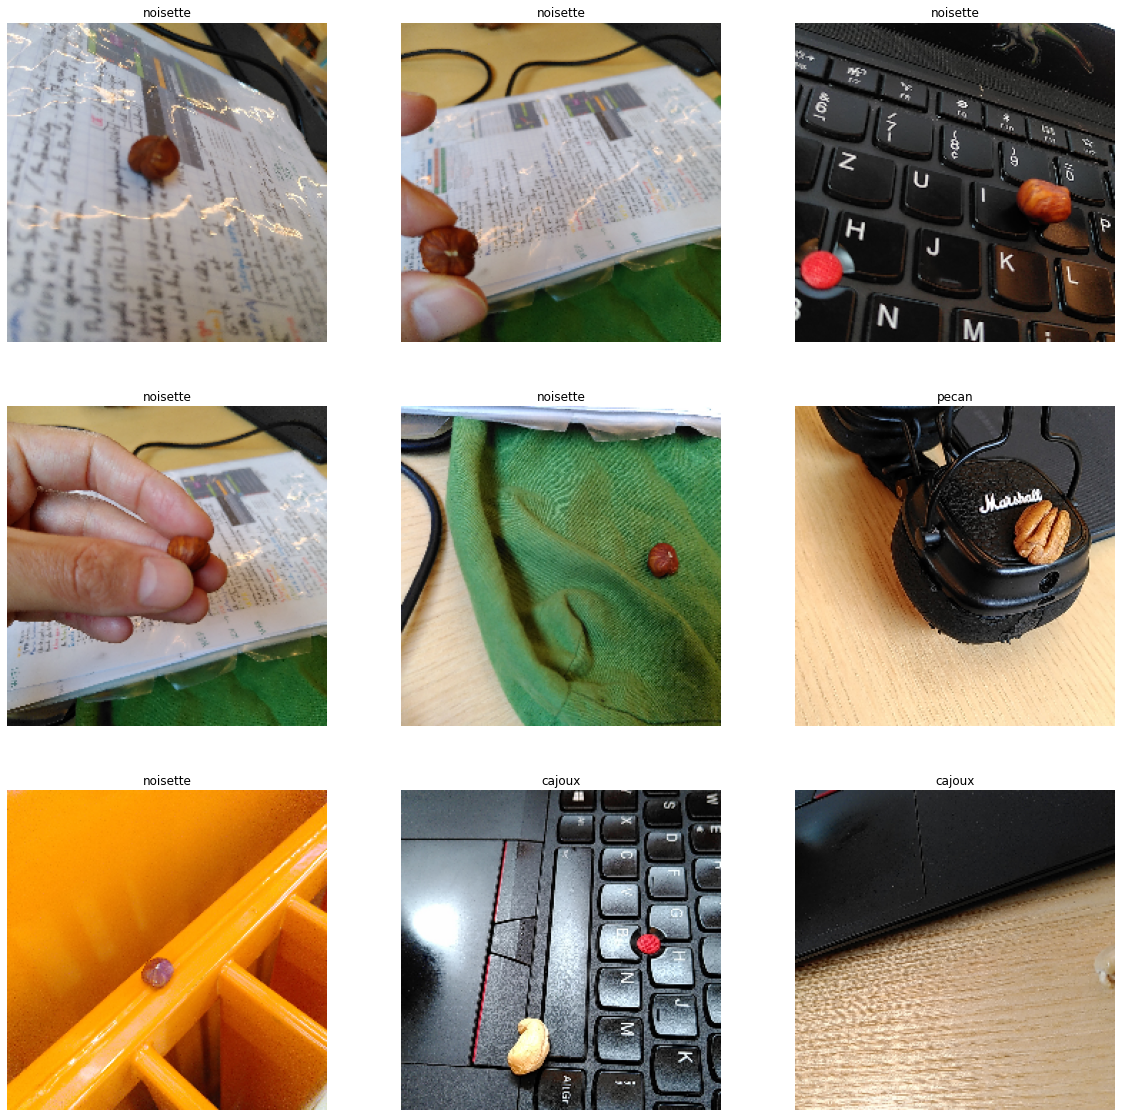

In [8]:
plt.figure(figsize=(20, 20))
sample = train_df.sample(frac=1).head(9).iterrows()
i = 0
images = []
for _, rowdata in train_df.sample(frac=1).head(9).iterrows():
    ax = plt.subplot(3, 3, i + 1)
    images.append(rowdata.path)
    plt.imshow(open_image(rowdata.path))
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1
print(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


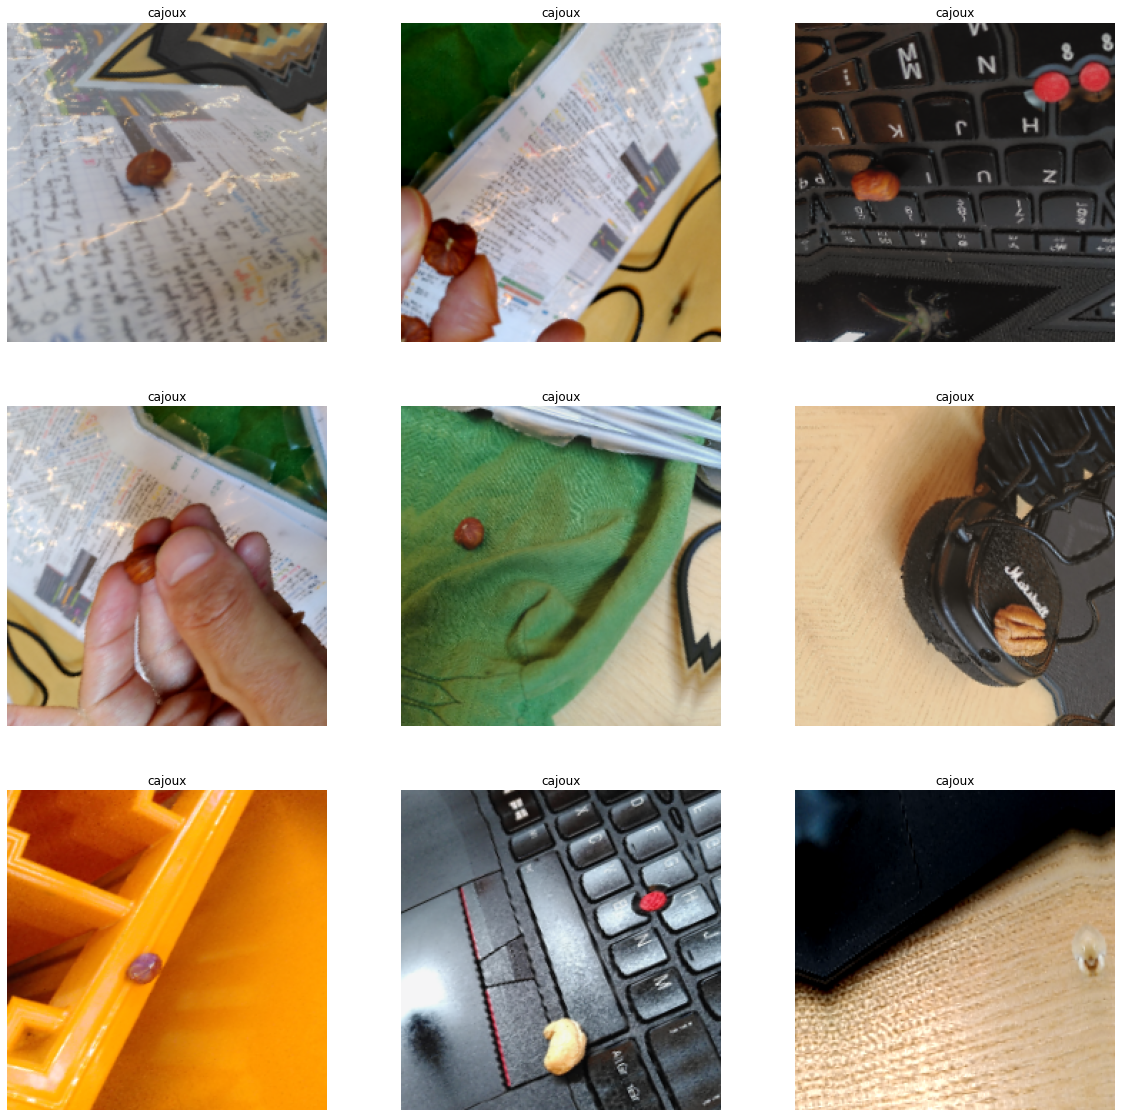

In [9]:
images = open_images(images)
plt.figure(figsize=(20, 20))
i = 0
for im in images:
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_augmentations(im))
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1

## Define model

In [10]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    Dropout
)

def get_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )
    
    layers = base_model.output

    added_layers = [
        # important, we need global average pooling instead of flatten for class activation map later on 
        GlobalAveragePooling2D(), 
        # TODO: ...
        Dense(256, activation='relu'),
        Dense(3, activation='softmax')
    ]

    model = Model(inputs=base_model.input, outputs=Sequential(added_layers)(layers))

    # TODO: freeze layers
    for layer in model.layers[:-2]:
        layer.trainable=False
    for layer in model.layers[-2:]:
        layer.trainable=True
    
    model.compile(
      optimizer = RMSprop(),
      loss = SparseCategoricalCrossentropy(),
      metrics = ['acc']
    )
        
    return model

In [11]:
model = get_model()
get_model().summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

# Model training

**TODO**: cross-validate your model, you can base yourself on the code from the first part of this practical work

**NOTE**: you shouldn't augment validations images. What we want to evaluate is the performances on "real" images, not on images that are augmented and change all the time 

In [12]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

dataframe = pd.DataFrame(train_df, columns = ["path", "label"])
shuffled_dataset = dataframe.sample(frac=1, random_state=1234).reset_index(drop=True)

dataset_paths = shuffled_dataset['path'].to_numpy()
dataset_labels = shuffled_dataset['label'].to_numpy()

total_train_paths, test_paths, total_train_labels, test_labels = train_test_split(
    dataset_paths, dataset_labels, test_size=0.2, random_state=1234
)

# We need to convert from string labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(dataset_labels)
total_train_labels = label_encoder.transform(total_train_labels)
test_labels = label_encoder.transform(test_labels)

NB_EPOCHS = 6

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for train_index, val_index in KFold(n_splits=5).split(total_train_paths, total_train_labels):
    train_images = open_images(total_train_paths[train_index])    
    train_labels = total_train_labels[train_index]
    
    val_images = open_images(total_train_paths[val_index])
    val_labels = total_train_labels[val_index]
    
    model = get_model() # We reinitialize the model
    
    history = model.fit(
        x=train_images,
        y=train_labels,
        batch_size=64,
        validation_data=[val_images, val_labels],
        epochs=NB_EPOCHS,
    )
    
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])

Epoch 1/6


2022-06-08 14:20:48.048066: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 313810944 exceeds 10% of free system memory.


1/3 [=========>....................] - ETA: 8s - loss: 1.0828 - acc: 0.4844

2022-06-08 14:20:49.562007: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 313810944 exceeds 10% of free system memory.


3/3 [==============================] - 9s 2s/step - loss: 2.3900 - acc: 0.4261 - val_loss: 1.7471 - val_acc: 0.5227
Epoch 2/6


2022-06-08 14:20:54.475850: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 313810944 exceeds 10% of free system memory.


1/3 [=========>....................] - ETA: 3s - loss: 2.0924 - acc: 0.5156

2022-06-08 14:20:55.996721: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 313810944 exceeds 10% of free system memory.


3/3 [==============================] - 5s 2s/step - loss: 2.1753 - acc: 0.5114 - val_loss: 0.8893 - val_acc: 0.6818
Epoch 3/6


2022-06-08 14:20:59.734471: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 313810944 exceeds 10% of free system memory.


3/3 [==============================] - 5s 2s/step - loss: 0.4082 - acc: 0.8295 - val_loss: 0.2986 - val_acc: 0.9091
Epoch 4/6
3/3 [==============================] - 5s 2s/step - loss: 0.1543 - acc: 0.9773 - val_loss: 0.3455 - val_acc: 0.8636
Epoch 5/6
3/3 [==============================] - 5s 2s/step - loss: 0.1501 - acc: 0.9773 - val_loss: 0.3110 - val_acc: 0.8636
Epoch 6/6
3/3 [==============================] - 5s 2s/step - loss: 0.1217 - acc: 0.9830 - val_loss: 0.2609 - val_acc: 0.9318
Epoch 1/6
3/3 [==============================] - 9s 2s/step - loss: 3.9499 - acc: 0.3920 - val_loss: 1.9358 - val_acc: 0.4773
Epoch 2/6
3/3 [==============================] - 5s 2s/step - loss: 1.3683 - acc: 0.5511 - val_loss: 1.1153 - val_acc: 0.5909
Epoch 3/6
3/3 [==============================] - 5s 2s/step - loss: 0.5755 - acc: 0.7727 - val_loss: 0.6472 - val_acc: 0.6818
Epoch 4/6
3/3 [==============================] - 6s 2s/step - loss: 0.2769 - acc: 0.9261 - val_loss: 0.5987 - val_acc: 0.7500
Ep

# Results

**TODO**: plot the results from your crossvalidation

In [13]:
def plot_kfold_mean_performance(ax, train_performances, val_performances, measure_name):
    train_mean = np.mean(train_performances, axis=0)
    val_mean = np.mean(val_performances, axis=0)
    train_sd = np.std(train_performances, axis=0)
    val_sd = np.std(val_performances, axis=0)
    
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean+train_sd, facecolor='blue', alpha=0.5, label='Train')
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean-train_sd, facecolor='blue', alpha=0.5)

    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean+val_sd, facecolor='orange', alpha=0.5, label='Val')
    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean-val_sd, facecolor='orange', alpha=0.5)

    ax.set_xticks(np.arange(NB_EPOCHS))

    ax.set_ylabel(measure_name)
    ax.set_xlabel('Number of epochs')
    #pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    ax.legend()
    ax.grid()

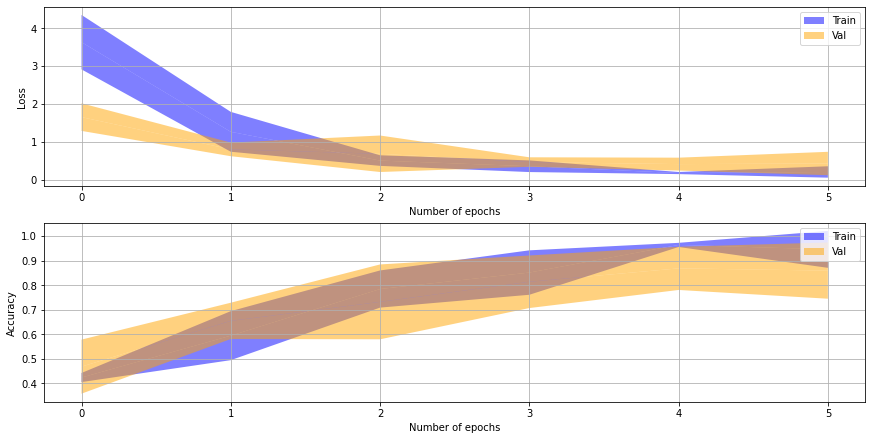

In [14]:
import matplotlib.pyplot as pl

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(12,6))

plot_kfold_mean_performance(axs[0], train_losses, val_losses, "Loss")
plot_kfold_mean_performance(axs[1], train_accuracies, val_accuracies, "Accuracy")

## Evaluate model on test set

**TODO**: when you've selected a final model, evaluate its performances (f-score, confusion matrix, ...) on your test set

### Display some misclassified images

**TODO**: display some misclassified images to be able to see what images are difficult for the model

## Use grad-cam to inspect how the model classify
Here we can see an heatmap of the regions that activates the model the most.

### For more information:
- tf-keras-vis documentation: https://keisen.github.io/tf-keras-vis-docs/
- Grad-cam paper: https://arxiv.org/pdf/1610.02391.pdf
- Grad-cam++ paper: https://arxiv.org/pdf/1710.11063.pdf

**NOTE**: maybe you will need to adapt some variable names based on your code above. For example, _model_ should be the model trained on all the training data. 

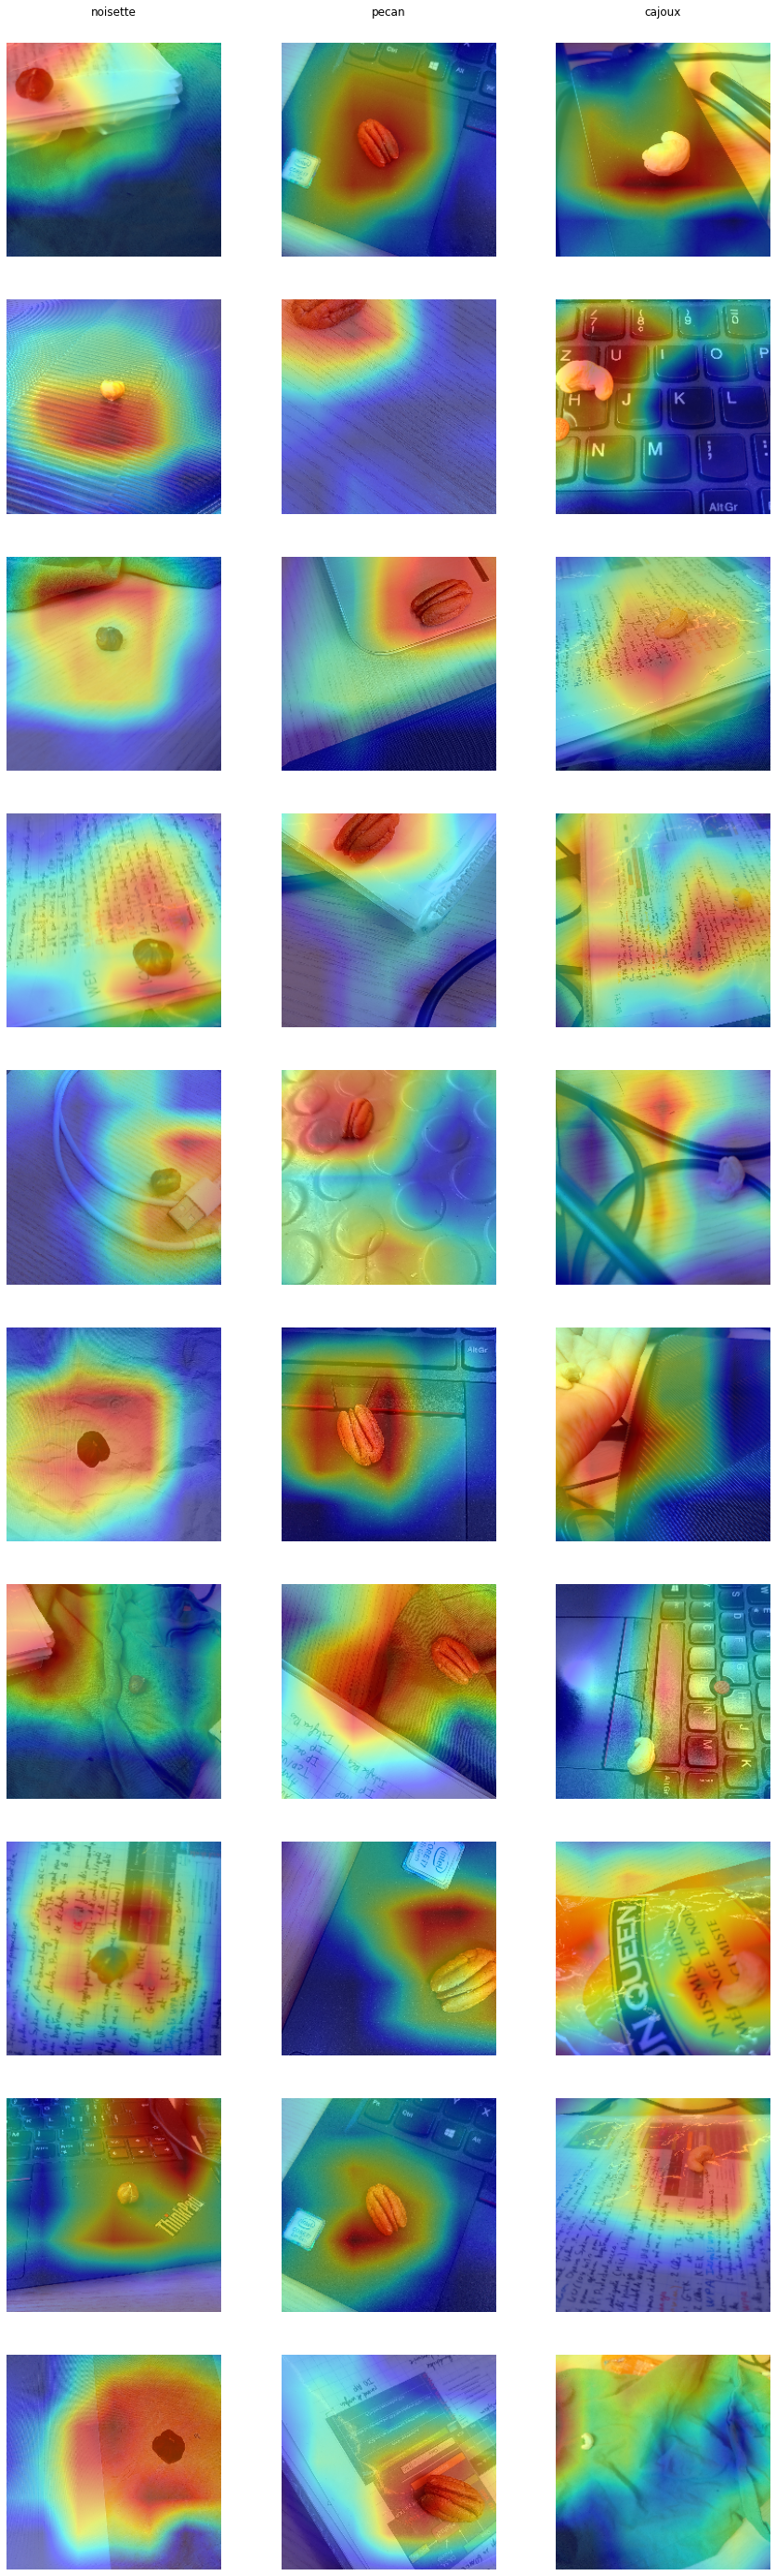

In [15]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tensorflow.keras.applications import MobileNetV2
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Create GradCAM++ object
gradcam = GradcamPlusPlus(
    model,
    model_modifier=ReplaceToLinear(),
    clone=True,
)

nb_images_per_class = 10

fig, axs = plt.subplots(nb_images_per_class, len(LABEL_NAMES), figsize=(len(LABEL_NAMES) * 5, nb_images_per_class * 5))

for label_idx, label_name in enumerate(LABEL_NAMES):
    axs[0,label_idx].set_title(label_name, loc='center', y=1.1)
    
    i = 0
    for _, rowdata in train_df[train_df['label'] == label_name].sample(frac=1).head(nb_images_per_class).iterrows():
        img = open_image(rowdata.path)    
        pred = model(np.expand_dims(img, axis=0))

        # Generate cam with GradCAM++
        score = CategoricalScore(np.argmax(pred))
        cam = gradcam(score, img)
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

        axs[i,label_idx].imshow(img, vmin=0, vmax=1)
        axs[i,label_idx].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        axs[i,label_idx].axis("off")

        i += 1

### Grad-cam on misclassified images

**TODO**: now do the same than above, but with the misclassified images. You shouldn't change anything pertaining to grad-cam besides on which image and prediction you do it

**TODO**: try to determine what caused the misclassifcations and what you can do about it